#Hands On Machine Learning Chapter 3
#Classification!

We will use the MNIST dataset!

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np

In [ ]:
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])



1.   DESCR -> dataset description
2.   data -> one row per example and one column per feature
3.   target -> array of labels


In [ ]:
X, y = mnist["data"], mnist["target"]

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

> There are 70,000 images and 784 features as each image is 28x28 pixels grayscale.

> Each pixel has a value between 0 (white) and 255 (black).

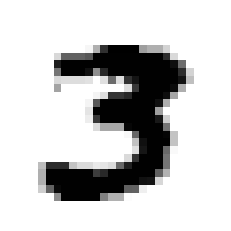

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt


some_digit = X[27]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

That's a 3 if I 'er seen one.

In [ ]:
y[27]

'3'

In [ ]:
y = y.astype(np.uint8)

This MNIST dataset is already split into 60000 (training) and the last 10000(test) images.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier


Let us start with a simpler task of identifying if the digit is 5 or not.

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

First, we will use SGD (Stochastic Gradient Descent) which is capable of handling large data sets and also usable for online learning.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now, let's test it on a digit.

In [ ]:
sgd_clf.predict([some_digit])

array([False])

It predicts a 3 as False! so that's correct :3

# Model Evaluation!

1. Cross Validation

    **split training set into K-folds with 3 parts training and one part test, and compare those results.**

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

**IMPORTANT:** Accuracy is a metric as the ratio of correct predictions.

Results look good, but before we decide that this is the best classifier, let's look a classifier that predicts all images as not-five.

### Dumb classifier

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

wait, what? That's 90% accuracy on a classifier that predicts the same thing EVERYTIME!!!

That's because out of 70000 images, **only 10% images are of 5s** while the others are **not 5s**.

Hence, if you always predicted that an image is **not 5**, you will be right 90% of times.

In [ ]:
class Always5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.ones((len(X), 1), dtype = bool)

In [ ]:
always_5_clf = Always5Classifier()
cross_val_score(always_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.08875, 0.09145, 0.09085])

As expected, ~8-10% accuracy on a classifier that predicts 5 everytime.

So, this is obviously not a good metric to measure classifier.

### Confusion Matrix



*   The number of times class A was classified as class B is at the **Ath row** and **Bth column**!



In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

**cross_val_predict** will perform K-fold cross validation, but instead of returning the scores, it returns the predictions made on each test fold.

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

**REMEMBER**: Each row in confusion matrix represents **actual class**. Each column in confusion matrix represents **predicted class**.

In our case, the first row contains non-five images, out of which 53892 were predicted correctly and 687 were predicted as fives.

The second row contains fives, out of which 1891 were predicted wrongly and 3530 were predicted as fives.

##### Some metrics based on confusion matrix:
1. Precision: accuracy of positive predictions. Ratio of instances predicted positively vs. instances falsely predicted positively.
    \begin{align}
    \frac{TP}{TP + FP}
    \end{align}

This is typically used with another metric called **recall** or **sensitivity** or **true positive rate**.
2. Recall: ratio of positive instances correctly detected. Ratio of positive instances predicted positively vs. positive instances predicted negatively.

    \begin{align}
    \frac{TP}{TP + FN}
    \end{align}

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

When our predictor **predicts five**, it is five only 83% of times.

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Our predictor only **predicts 65% of 5s correctly**.

#### F1 Score!

It is the **harmonic mean** of recall and precision.

Regular mean treats all values equally, whereas harmonic mean gives much more weight to **low values** and hence, the score is high only when **recall and precision are both high**.

\begin{align}
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
\end{align}

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

This is a good overall measure, but may not be the best measure in every case.

For example, if you trained a classifier **to detect videos safe for kids**, you would prefer a classifier where **many good videos are rejected** (low recall) but **only safe ones** are kept. (high precision).

On the other hand, suppose you trained a classifier **to detect shoplifters on surveillance images**, you only care about **every shoplifter getting caught** (high recall), and it doesn't matter even if **someone is falsely predicted to be shoplifting** (low precision).

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label = "Recall")
    plt.axis([-50000, 50000, 0, 1])

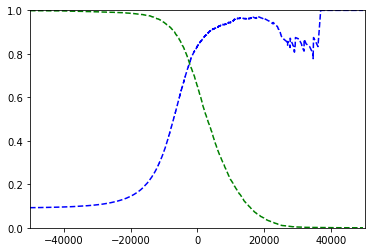

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Now, suppose we want 90% precision, so we can search for the first index where precision >= 0.90.

Then we can take that corresponding threshold!

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

Now, we can just use this threshold to get our predictions.

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

Perfect!

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

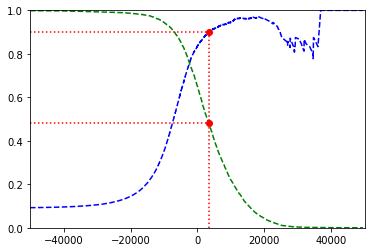

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  # Line separating area where precision < 90% and >= 90%.
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                 # Same for precision
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") # Line for recall
plt.plot([threshold_90_precision], [0.9], "ro") # Intersection point for precision
plt.plot([threshold_90_precision], [recall_90_precision], "ro") # Intersection point for recall
plt.show()

#### ROC Curve!

**Receiver Operating Characteristic** Curve 😳😵

It is the plot of **True Positive Rate (TPR)** or **Recall** and **False Positive Rate (FPR)** or **1 - True Negative Rate (TNR) (Specificity)**.

FPR: ratio of negative instances falsely classified as positive.

\begin{align}
    \frac{FP}{TN + FP}
\end{align}

So basically, how many negatives are falsely classified as positive?

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

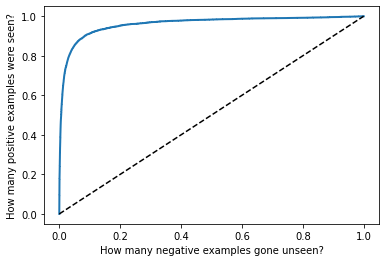

In [ ]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("How many negative examples gone unseen?")
    plt.ylabel("How many positive examples were seen?")

plot_roc_curve(fpr, tpr)
plt.show()

So, basically, a perfect classifier would have 0 False Positive Rate and 1 True Positive Rate.

Meaning, no negative example should go unseen or should be falsely classified and all positive examples should be classifier correctly!

But again, there's a slight tradeoff.

As the TPR increases, the FPR also increases.

##### AUC

So, usually, this curve is defined by the area under its curve, often denoted as **Area Under the Curve**.

For a perfect classifier, this area is equal to 1.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Precision-Recall vs ROC



In general,

**When positive class is rare**, **When you care more about false positives**, use **Precision-Recall** because if **false positives are more** or if **true negatives are more**, our ROC curve will be pushed towards the left side, and will be misleading. 

**Otherwise**, use **ROC**

Let us compare SGDClassifier with RandomForestClassifier.

For RandomForestClassifier, to get decision scores we have **predict_proba()**.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [ ]:
pos_scores = y_probs_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, pos_scores)

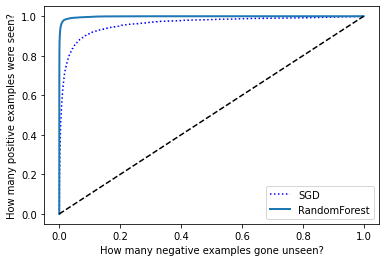

In [ ]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc = "lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, pos_scores)

0.9983436731328145

In [ ]:
preds = pos_scores >= 0.5

In [ ]:
precision_score(y_train_5, preds)

0.9897468089558485

In [ ]:
recall_score(y_train_5, preds)

0.8725327430363402

# Multiclass Classification!

## One-versus-all (OvA)
Train a binary classifier for each class which outputs a decision score, and then out of those we select the class with highest decision score.


## One-versus-one (OvO)
Train a binary classifer for each pair of classes: one for 0s and 1s, another for 0s and 2s, one for 1s and 2s, etc.

This results in 45 binary classifiers for 10 classes.

The main advantage here is that, each classifier has to be trained only on the part of the two classes it has to distinguish between.

**NOTE:** Scikit-Learn uses OvA except for SVM classifiers.

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-40934.948741  , -42647.68638216, -10431.39688285,
         12790.93016539, -31036.1849965 , -10439.85609919,
        -88423.68582293, -19437.41602322,  -2361.34091491,
        -18183.16922972]])

In [ ]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
len(ovo_clf.estimators_)

45

In [ ]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([3], dtype=uint8)

For SGDClassifier, Scikit-Learn automatically uses OvA strategy, but Scikit-Learn doesnt have to do that for Random Forest Classifiers as they are already equipped for multiclass classification.

In [ ]:
some_digit_scores = forest_clf.predict_proba([some_digit])
some_digit_scores

array([[0.  , 0.  , 0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.  , 0.02]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

We can already see ~0.9 accuracy just by scaling the input.

Now, we will assume that we have already found a promising model, and will now find ways to improve it, rather than performing the steps in the previous chapter.

In [51]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
confusion_mat = confusion_matrix(y_train, y_train_pred)
confusion_mat

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

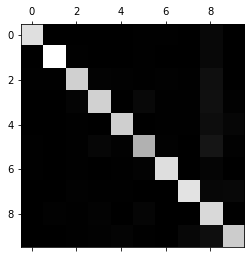

In [52]:
plt.matshow(confusion_mat, cmap = plt.cm.gray)
plt.show()

Looks pretty good! As the diagonal is fairly white, it means its predicting quite well.

But, for the number 5, the diagonal square looks a more gray, meaning either there is not enough data for it, or it is not predicting 5s well.

Now, to find the normalized error across all the classes, let us divide the values in confusion matrix by the number of images in the corresponding class.

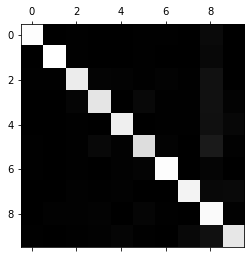

In [53]:
row_sums = confusion_mat.sum(axis = 1, keepdims = True)
norm_confusion_mat = confusion_mat / row_sums
plt.matshow(norm_confusion_mat, cmap = plt.cm.gray)
plt.show()

In [54]:
norm_confusion_mat

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

In [55]:
np.fill_diagonal(norm_confusion_mat, 0)
norm_confusion_mat

array([[0.        , 0.        , 0.00371433, 0.00084417, 0.00135067,
        0.00725983, 0.006078  , 0.001013  , 0.03798751, 0.00016883],
       [0.        , 0.        , 0.00548799, 0.00355977, 0.0005933 ,
        0.00652625, 0.0005933 , 0.00103827, 0.03144468, 0.00148324],
       [0.00453172, 0.00453172, 0.        , 0.01544142, 0.01225243,
        0.00453172, 0.01124538, 0.0060423 , 0.06344411, 0.00184626],
       [0.00358832, 0.00277279, 0.01908335, 0.        , 0.00032621,
        0.03311042, 0.00440385, 0.00652422, 0.06573153, 0.0119067 ],
       [0.00205409, 0.00239644, 0.00701814, 0.00154057, 0.        ,
        0.00205409, 0.00581992, 0.0046217 , 0.05939747, 0.02807258],
       [0.00498063, 0.00276702, 0.00553403, 0.03099059, 0.00977679,
        0.        , 0.01383509, 0.00258255, 0.09869028, 0.01106807],
       [0.00506928, 0.00253464, 0.00709699, 0.00050693, 0.00743494,
        0.01639067, 0.        , 0.00050693, 0.02213586, 0.00016898],
       [0.00335196, 0.00159617, 0.0081404

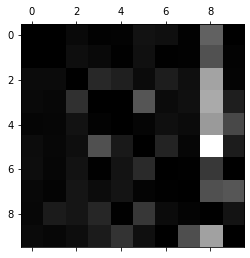

In [56]:
plt.matshow(norm_confusion_mat, cmap = plt.cm.gray)
plt.show()

So, it can be seen that the column (predicted) for 8 is very bright, meaning that a lot of digits get classified as 8s.

However, the row (true) for 8 is normal, meaning that 8s are also being classified as 8s.

Now, to improve this, we should focus on reducing the false 8s by either gathering more training data for digits looking like 8 but are not 8s, or use some other preprocessing to distinguish between 8s and other digits.

To see why our classifier is doing this, let us plot some 5s and 8s.

In [57]:
cl_a, cl_b = 5, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # Images that are 5s and classified as 5s.
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # Images that are 5s but classified as 8s.
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # Images that are 8s but classified as 5s.
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # Images that are 8s and classified as 8s.

In [85]:
from math import ceil
def plot_digits(images, images_per_row, name):
    total_rows = ceil(len(images) / images_per_row)
    for i, j in enumerate(images, 1):
        plt.subplot(total_rows, images_per_row, i)
        plt.imshow(j.reshape(28, 28), cmap = mpl.cm.binary, interpolation = "nearest")
        plt.axis("off")
    plt.savefig(name + ".jpg")

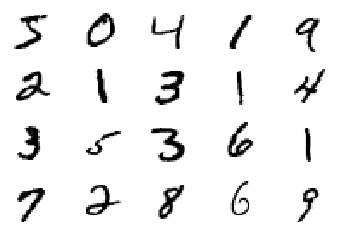

In [86]:
example_images = X_train[:20]
plot_digits(example_images, 5, "example")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


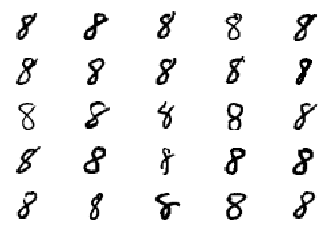

In [88]:
plot_digits(X_aa[:25], 5, "5s")
plot_digits(X_ab[:25], 5, "5s classified 8s")
plot_digits(X_ba[:25], 5, "8s classified 5s")
plot_digits(X_bb[:25], 5, "8s")

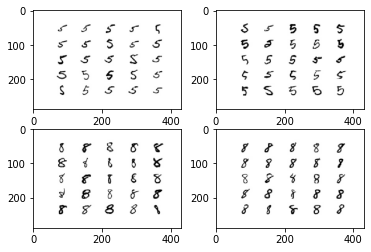

In [94]:
import matplotlib.image as mpimg
img1 = mpimg.imread("5s.jpg")
img2 = mpimg.imread("5s classified 8s.jpg")
img3 = mpimg.imread("8s classified 5s.jpg")
img4 = mpimg.imread("8s.jpg")
plt.subplot(221); plt.imshow(img1)
plt.subplot(222); plt.imshow(img2)
plt.subplot(223); plt.imshow(img3)
plt.subplot(224); plt.imshow(img4)
plt.show()

As can be seen, this mishap may be happening as we are using a linear SGD Classifier which is done by assigning a weight to a pixel.

## Multilabel Classification

Till now, we have only seen classifiers where it outputs only one result.
But multilabel classifiers are used to output multiple output classes for each instance.

For example, if a multiclass classifier detects either a 3 or a 5 in a picture.
A multilabel classifier would detect both 3 and 5 in a picture.

In [97]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]  # This will assign two labels to each example, if the example is [large, odd].

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Now, let us have it classify the set of 5s.

In [101]:
results = knn_clf.predict(np.concatenate((X_aa, X_ab), axis = 0))

In [102]:
np.unique(results)

array([False,  True])

Ok! So, seems like it predicted every 5 to be odd and not large! Which is absolutely correct.

In [103]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605

## Multioutput Classification

Each output is multilabel where each label is multiclass 😃help


We will create a model that will remove noise from our dataset. Input are noisy images and the output is a cleaned image.

In [104]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

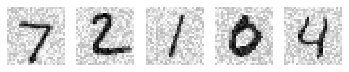

In [106]:
plot_digits(X_test_mod[:5], 5, "modified noisy images")

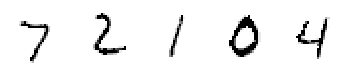

In [107]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod[:5])
plot_digits(clean_digit, 5, "predicted clean images")

O_O looks pretty well done!

# Exercises